# architecture-09 ( Basic Regression Wide And Deep copy from 05 )
What's new:

1-

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Concatenate, GlobalAveragePooling1D, LayerNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import talib
from tensorflow.keras import callbacks
from tensorflow.keras import Input, Model


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Concatenate, GlobalAveragePooling1D, LayerNormalization

In [6]:
# === Load and preprocess ===
df = pd.read_csv('datasets-09/XAGUSD-H1-rates.csv', sep='\t').dropna()

# Scale sequence features
sequence_features = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']
wide_features = ['<SPREAD>', '<VOL>']

scaler_seq = MinMaxScaler()
scaler_wide = MinMaxScaler()
scaler_close = MinMaxScaler()

scaled_seq = scaler_seq.fit_transform(df[sequence_features])
scaled_wide = scaler_wide.fit_transform(df[wide_features])
scaled_close = scaler_close.fit_transform(df[['<CLOSE>']])

# === Create sequences ===
def create_sequences(seq_data, wide_data, target_data, window, horizon):
    X_seq, X_wide, y = [], [], []
    for i in range(window, len(seq_data) - horizon):
        X_seq.append(seq_data[i-window:i])
        X_wide.append(wide_data[i-1])  # use last row of each window
        y.append(target_data[i:i+horizon].flatten())
    return np.array(X_seq), np.array(X_wide), np.array(y)

WINDOW_SIZE = 60
FORECAST_HORIZON = 10

X_seq, X_wide, y = create_sequences(scaled_seq, scaled_wide, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)

# === Train/Test split ===
X_seq_train, X_seq_test, X_wide_train, X_wide_test, y_train, y_test = train_test_split(
    X_seq, X_wide, y, test_size=0.2, shuffle=False
)

# === Build Wide & Deep model ===
def build_wide_deep_model(seq_shape, wide_shape, horizon):
    # Deep part
    seq_input = Input(shape=seq_shape, name="sequence_input")
    x = LSTM(64, return_sequences=True)(seq_input)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    # Wide part
    wide_input = Input(shape=wide_shape, name="wide_input")

    # Combine
    combined = Concatenate()([x, wide_input])
    x = Dense(64, activation='relu')(combined)
    x = Dense(32, activation='relu')(x)
    output = Dense(horizon)(x)

    model = Model(inputs=[seq_input, wide_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_wide_deep_model(
    seq_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
    wide_shape=(X_wide_train.shape[1],),
    horizon=FORECAST_HORIZON
)

# === Train ===
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_seq_train, X_wide_train],
    y_train,
    validation_split=0.2,
    epochs=2,
    callbacks=[es],
    verbose=1
)

# === Predict on new 60-row input ===
input_df = pd.read_csv('datasets-09/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv', sep='\t').dropna()
input_seq_scaled = scaler_seq.transform(input_df[sequence_features])
input_wide_scaled = scaler_wide.transform(input_df[wide_features])

input_seq = np.expand_dims(input_seq_scaled, axis=0)        # (1, 60, 5)
input_wide = np.expand_dims(input_wide_scaled[-1], axis=0)  # (1, 2)

pred = model.predict([input_seq, input_wide])
prediction = scaler_close.inverse_transform(pred)
print("Next 10 predicted closing prices:", prediction.flatten())


Epoch 1/50


2025-06-24 07:01:06.463789: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42249600 exceeds 10% of free system memory.


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0073 - mae: 0.0372 - val_loss: 0.0017 - val_mae: 0.0341
Epoch 2/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 4.1514e-04 - mae: 0.0140 - val_loss: 7.8873e-04 - val_mae: 0.0219
Epoch 3/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - loss: 3.5796e-04 - mae: 0.0133 - val_loss: 0.0034 - val_mae: 0.0546
Epoch 4/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 3.1108e-04 - mae: 0.0119 - val_loss: 8.6423e-04 - val_mae: 0.0232
Epoch 5/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 2.9312e-04 - mae: 0.0119 - val_loss: 7.4888e-04 - val_mae: 0.0205
Epoch 6/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 2.4137e-04 - mae: 0.0105 - val_loss: 8.3483e-04 - val_mae: 0.0245
Epoch 7/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - loss: 2.2215e-04 - mae: 0.0103 - val_loss: 4.3572e-04 - val_mae: 0.0162
Epoch 8/50
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - loss: 1.9310e-04 - mae: 0.0097 - val_loss: 0.0013 - val

# plot section

In [7]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-09/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-09/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

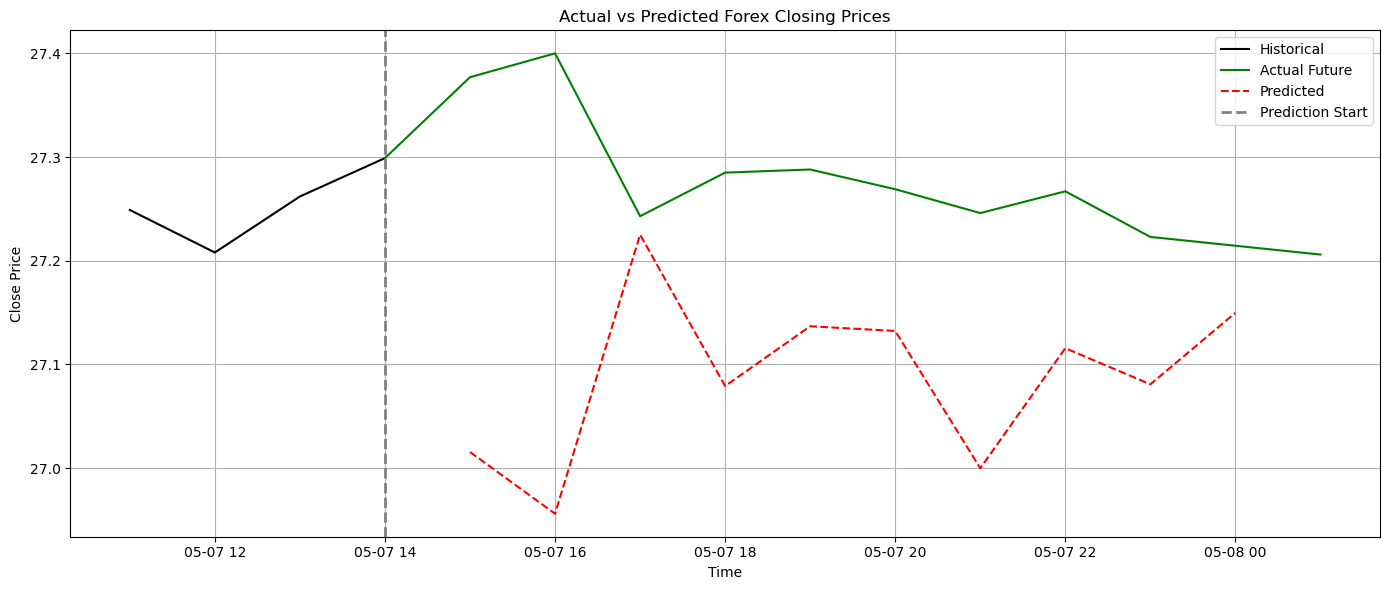

In [8]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [9]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')


NameError: name 'X_test' is not defined